In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import shutil
from math import log, exp
import pickle
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [2]:
df = pd.read_csv('/kaggle/input/genre-synonyms/genre_synonyms(final).csv')

texts = df['features'].values
labels = df['labels'].values

In [3]:
class CustomTFIDF:
    def __init__(self):
        self.idf = {}
        self.word_to_index = {}
        self.index_to_word = {}

    def fit_transform(self, corpus):
        num_docs = len(corpus)
        term_doc_count = defaultdict(int)
        tokenized_corpus = []

        for doc in corpus:
            tokens = doc.split()
            tokenized_corpus.append(tokens)
            unique_tokens = set(tokens)
            for token in unique_tokens:
                term_doc_count[token] += 1

        for term, count in term_doc_count.items():
            self.idf[term] = log((num_docs + 1) / (count + 1)) + 1

        self.word_to_index = {word: idx for idx, word in enumerate(self.idf)}
        self.index_to_word = {idx: word for word, idx in self.word_to_index.items()}

        tfidf_matrix = []
        for tokens in tokenized_corpus:
            doc_vector = np.zeros(len(self.word_to_index))
            term_count = defaultdict(int)
            for token in tokens:
                term_count[token] += 1
            for term, count in term_count.items():
                if term in self.word_to_index:
                    idx = self.word_to_index[term]
                    tf = count / len(tokens)
                    doc_vector[idx] = tf * self.idf[term]
            tfidf_matrix.append(doc_vector)
        return np.array(tfidf_matrix)

    def transform(self, corpus):
        tfidf_matrix = []
        for doc in corpus:
            tokens = doc.split()
            doc_vector = np.zeros(len(self.word_to_index))
            term_count = defaultdict(int)
            for token in tokens:
                term_count[token] += 1
            for term, count in term_count.items():
                if term in self.word_to_index:
                    idx = self.word_to_index[term]
                    tf = count / len(tokens)
                    doc_vector[idx] = tf * self.idf.get(term, 0)
            tfidf_matrix.append(doc_vector)
        return np.array(tfidf_matrix)

In [4]:
class CustomLabelEncoder:
    def __init__(self):
        self.label_to_index = {}
        self.index_to_label = {}

    def fit_transform(self, labels):
        unique_labels = set(labels)
        self.label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
        self.index_to_label = {idx: label for label, idx in self.label_to_index.items()}
        return np.array([self.label_to_index[label] for label in labels])

    def inverse_transform(self, indices):
        return np.array([self.index_to_label[idx] for idx in indices])

In [5]:
vectorizer = CustomTFIDF()
label_encoder = CustomLabelEncoder()

X = vectorizer.fit_transform(texts)
y = label_encoder.fit_transform(labels)

In [6]:
class CustomNaiveBayes:
    def __init__(self):
        self.class_prior = {}
        self.feature_prob = {}

    def fit(self, X, y):
        num_docs, num_features = X.shape
        unique_classes, counts = np.unique(y, return_counts=True)
        self.class_prior = {cls: count / num_docs for cls, count in zip(unique_classes, counts)}

        feature_sum_by_class = {cls: np.zeros(num_features) for cls in unique_classes}
        for cls in unique_classes:
            X_cls = X[y == cls]
            feature_sum_by_class[cls] = X_cls.sum(axis=0) + 1

        total_features_per_class = {cls: np.sum(feature_sum_by_class[cls]) for cls in unique_classes}
        self.feature_prob = {
            cls: feature_sum_by_class[cls] / total_features_per_class[cls]
            for cls in unique_classes
        }

    def predict(self, X):
        predictions = []
        for x in X:
            class_scores = {}
            for cls in self.class_prior:
                log_prior = log(self.class_prior[cls])
                log_likelihood = sum(x * np.log(self.feature_prob[cls]))
                class_scores[cls] = log_prior + log_likelihood
            predictions.append(max(class_scores, key=class_scores.get))
        return np.array(predictions)

In [7]:
if not os.path.exists("saved_custom_models"):
    os.makedirs("saved_custom_models")

def save_model(model, model_name):
    with open(f"saved_custom_models/{model_name}_custom_model.pkl", "wb") as f:
        pickle.dump(model, f)
    print(f"{model_name} model saved!")

def save_vectorizer_and_encoder(vectorizer, label_encoder):
    with open('saved_custom_models/custom_vectorizer.pkl', 'wb') as f:
        pickle.dump(vectorizer, f)
    with open('saved_custom_models/custom_label_encoder.pkl', 'wb') as f:
        pickle.dump(label_encoder, f)
    print("Vectorizer and LabelEncoder saved!")

In [8]:
models = {
    "Naive Bayes": CustomNaiveBayes(),
}

model_metrics = {
    "Model": [],
    "Accuracy": []
}

for model_name, model in models.items():
    print(f"Training {model_name}...")
    model.fit(X, y)
    y_pred = model.predict(X)

    accuracy = np.mean(y_pred == y)
    model_metrics["Model"].append(model_name)
    model_metrics["Accuracy"].append(accuracy)

    print(f"{model_name} Accuracy: {accuracy}")

    save_model(model, model_name)

save_vectorizer_and_encoder(vectorizer, label_encoder)

shutil.make_archive('saved_custom_models', 'zip', 'saved_custom_models')
print("All models, vectorizer, and encoder saved into 'saved_custom_models.zip'")

Training Naive Bayes...
Naive Bayes Accuracy: 1.0
Naive Bayes model saved!
Vectorizer and LabelEncoder saved!
All models, vectorizer, and encoder saved into 'saved_custom_models.zip'


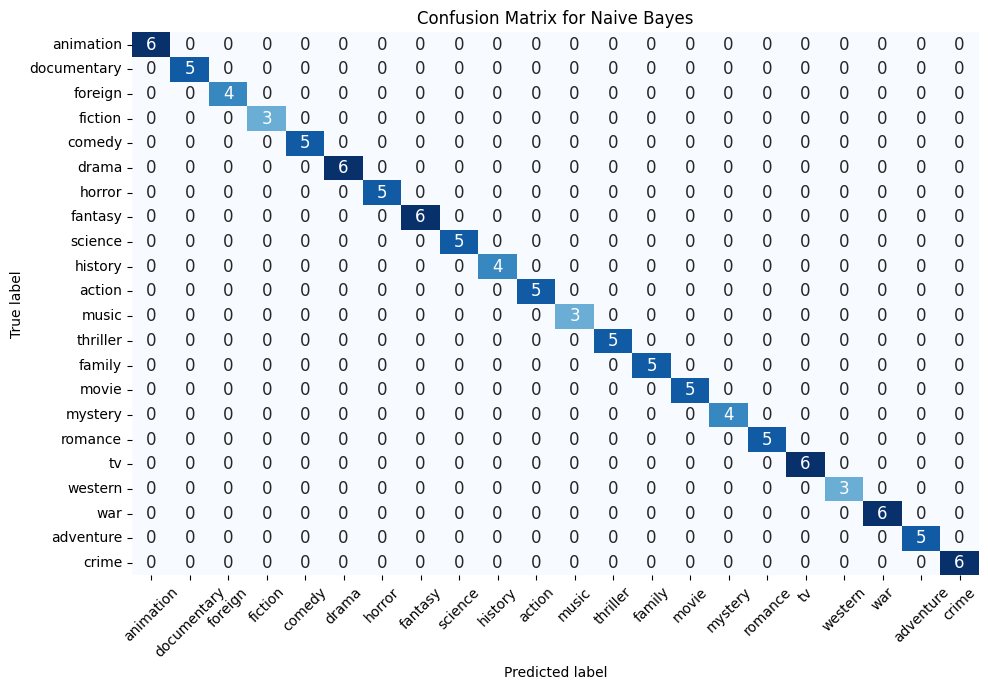

In [9]:
cm = confusion_matrix(y, y_pred)
cm_display = pd.DataFrame(cm, index=label_encoder.inverse_transform(np.unique(y)), columns=label_encoder.inverse_transform(np.unique(y)))

plt.figure(figsize=(10, 7))
sns.heatmap(cm_display, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"size": 12})
plt.title("Confusion Matrix for Naive Bayes")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [10]:
print("Classification Report for Naive Bayes:")
print(classification_report(y, y_pred, target_names=label_encoder.inverse_transform(np.unique(y))))

Classification Report for Naive Bayes:
              precision    recall  f1-score   support

   animation       1.00      1.00      1.00         6
 documentary       1.00      1.00      1.00         5
     foreign       1.00      1.00      1.00         4
     fiction       1.00      1.00      1.00         3
      comedy       1.00      1.00      1.00         5
       drama       1.00      1.00      1.00         6
      horror       1.00      1.00      1.00         5
     fantasy       1.00      1.00      1.00         6
     science       1.00      1.00      1.00         5
     history       1.00      1.00      1.00         4
      action       1.00      1.00      1.00         5
       music       1.00      1.00      1.00         3
    thriller       1.00      1.00      1.00         5
      family       1.00      1.00      1.00         5
       movie       1.00      1.00      1.00         5
     mystery       1.00      1.00      1.00         4
     romance       1.00      1.00      1.0

In [11]:
# Load the saved model, vectorizer, and label encoder
def load_model(model_name):
    with open(f"saved_custom_models/{model_name}_custom_model.pkl", "rb") as f:
        return pickle.load(f)

def load_vectorizer_and_encoder():
    with open('saved_custom_models/custom_vectorizer.pkl', 'rb') as f:
        vectorizer = pickle.load(f)
    with open('saved_custom_models/custom_label_encoder.pkl', 'rb') as f:
        label_encoder = pickle.load(f)
    return vectorizer, label_encoder

# Example of loading the model
loaded_model = load_model("Naive Bayes")
loaded_vectorizer, loaded_encoder = load_vectorizer_and_encoder()

test_inputs = ["action", "funny comedy", "battle adventure", "scary", "fantasy"]
X_test = vectorizer.transform(test_inputs)

for model_name, loaded_model in models.items():
    predictions = model.predict(X_test)
    decoded_predictions = label_encoder.inverse_transform(predictions)
    print(f"\n{model_name} Predictions for test inputs: {decoded_predictions}")


Naive Bayes Predictions for test inputs: ['action' 'comedy' 'adventure' 'horror' 'fantasy']
